## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
# Camera Calibration

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip

%matplotlib inline
#%matplotlib qt

class CameraHelper:

    def __init__(self, calibration_image_dir):

        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
        
        objpoints = []
        imgpoints = []
        
        images = glob.glob(calibration_image_dir + 'calibration*.jpg')
        img_shape = ()
        
        for idx, fname in enumerate(images):
            
            img = mpimg.imread(fname)
            img_shape = (img.shape[1], img.shape[0])
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
                
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(
            objpoints, imgpoints, img_shape, None, None)

    def Undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)

### Test Undistortion on sample images

In [3]:
cameraHelper = CameraHelper('./camera_cal/')

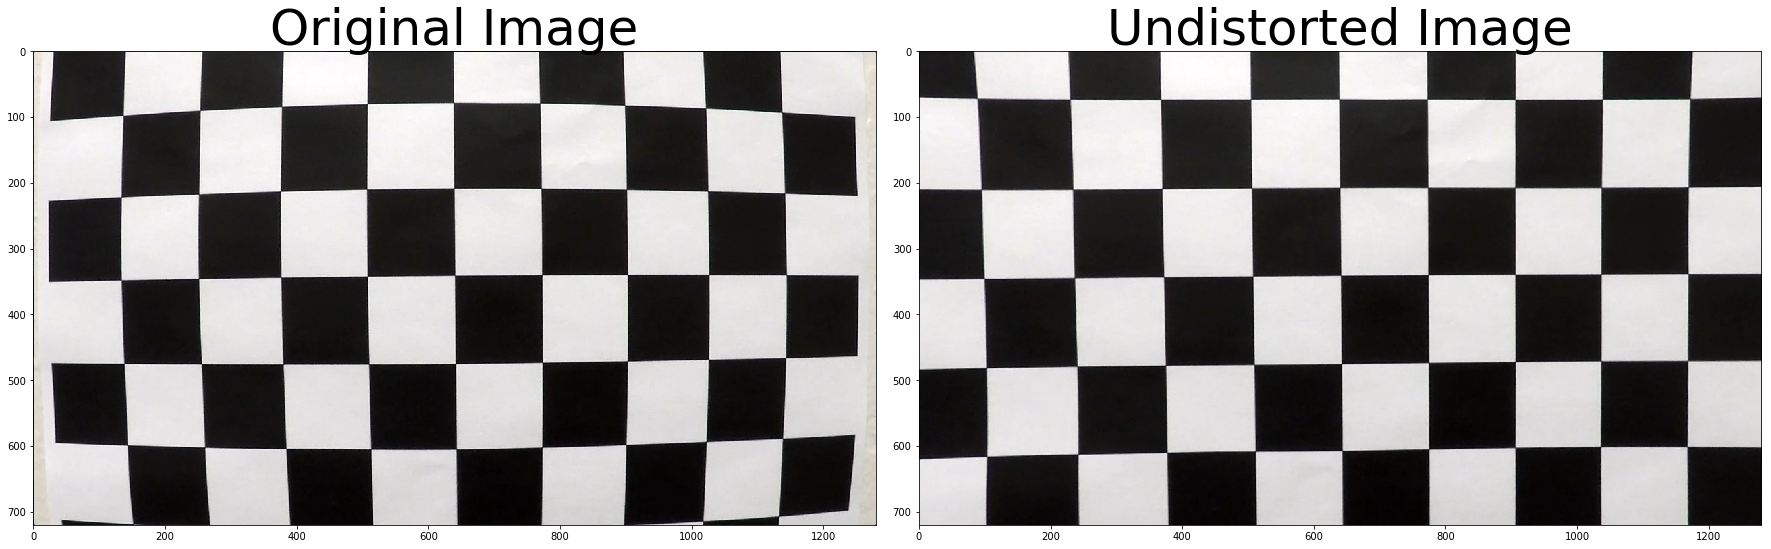

In [4]:
def test_undistortion():
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    img = mpimg.imread('./camera_cal/calibration1.jpg')
    ax1.imshow(img)
    ax2.imshow(cameraHelper.Undistort(img))
    ax1.set_title('Original Image', fontsize=50)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

test_undistortion()

# Color space and gradient thresholding

In [5]:
class Thresholder:
    
    def __init__(self,
                 sobel_kernel = 15,
                 threshx = (20, 100),
                 threshy = (20, 100),
                 threshmag = (40, 120),
                 threshdir = (0.77, 1.6),
                 threshhls=(90, 255)):
        
        self.sobel_kernel = sobel_kernel
        self.threshx = threshx
        self.threshy = threshy
        self.threshmag = threshmag
        self.threshdir = threshdir
        self.threshhls = threshhls
    
    def ApplySobelThreshold(self, img):
        
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=self.sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=self.sobel_kernel)
        
        absx = np.absolute(sobelx)
        x = np.uint8(255 * absx / np.max(absx))

        absy = np.absolute(sobely)
        y = np.uint8(255 * absy / np.max(absy))
        
        mag = np.sqrt(sobelx**2 + sobely**2)
        mag = (mag * 255 / np.max(mag)).astype(np.uint8) 

        dir = np.arctan2(sobely, sobelx)
        
        binary = np.zeros_like(gray)
        binary[(((x >= self.threshx[0]) & (x <= self.threshx[1])) & ((y >= self.threshy[0]) & (y <= self.threshy[1])))
              | (((mag >= self.threshmag[0]) & (mag <= self.threshmag[1])) & ((dir >= self.threshdir[0]) & (dir <= self.threshdir[1])))
              ] = 1
        
        return binary
    
    def ApplyColorThreshold(self, img):

        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        binary_output = np.zeros_like(s_channel)
        binary_output[(s_channel > self.threshhls[0]) & (s_channel <= self.threshhls[1])] = 1

        return binary_output
    
    def ApplySobelAndColorThreshold(self, undistorted):
        
        sobeled = self.ApplySobelThreshold(undistorted)
        colored = self.ApplyColorThreshold(undistorted)
        
        combined = np.zeros_like(colored)
        combined[(sobeled == 1)] = 60
        combined[(colored == 1)] += 180
        
        return combined

In [6]:
thresholder = Thresholder()

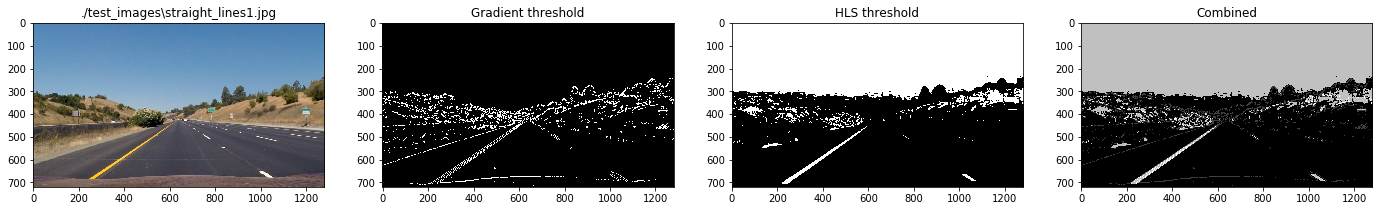

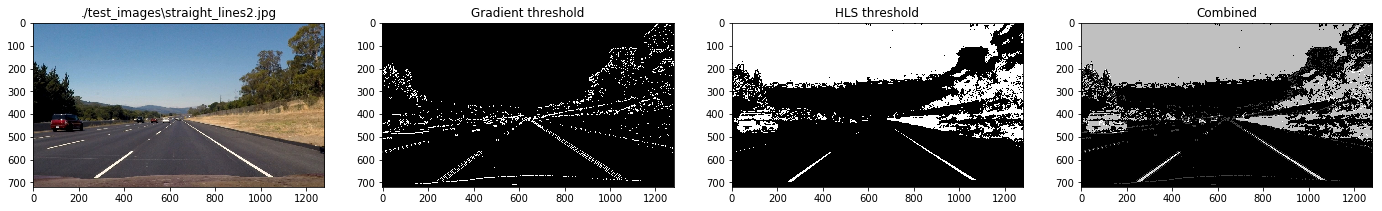

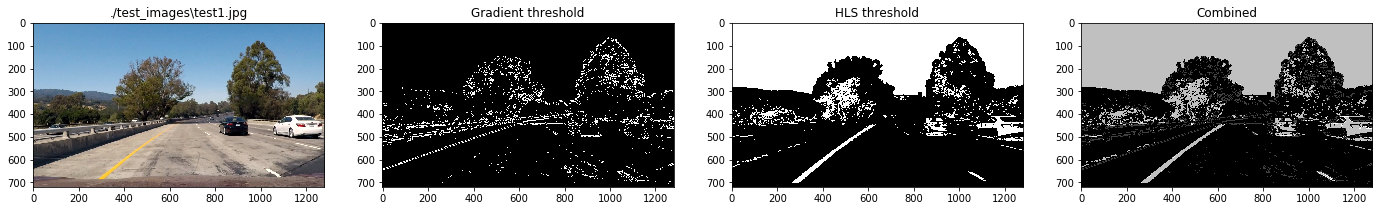

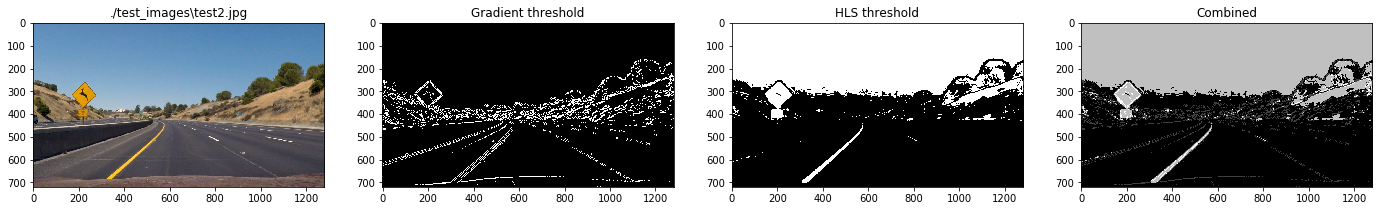

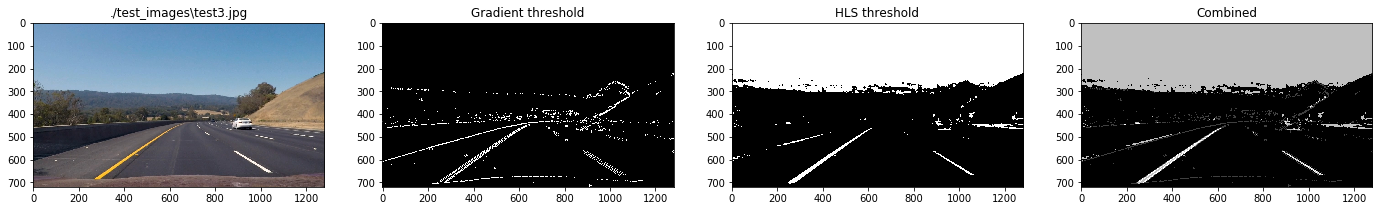

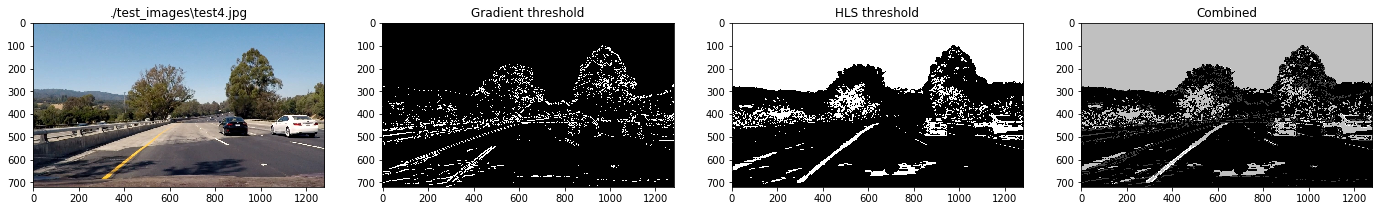

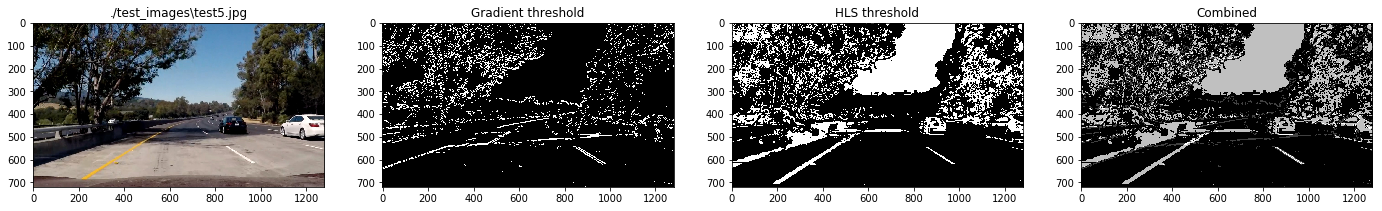

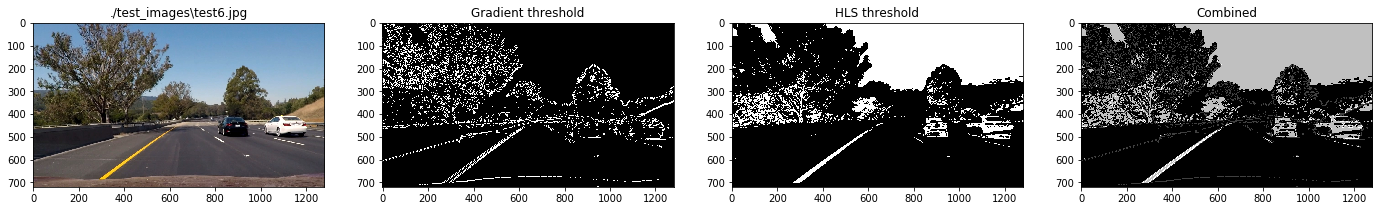

In [7]:
def test_on_images():
    
    images = glob.glob('./test_images/*.jpg')
    
    for idx, fname in enumerate(images):
        
        img = mpimg.imread(fname)
        undistorted = cameraHelper.Undistort(img)
        
        fig, (axs1, axs2, axs3, axs4) = plt.subplots(1, 4, figsize=(24, 9))
        axs1.imshow(img)
        axs2.imshow(thresholder.ApplySobelThreshold(undistorted), cmap = 'gray')
        axs3.imshow(thresholder.ApplyColorThreshold(undistorted), cmap = 'gray')
        axs4.imshow(thresholder.ApplySobelAndColorThreshold(undistorted), cmap = 'gray')
        
        axs1.set_title(fname)
        axs2.set_title('Gradient threshold')
        axs3.set_title('HLS threshold')
        axs4.set_title('Combined')

test_on_images()

# Perspective Transformation

In [38]:
#12 pixel increase
#lanePoints = np.array([[592, 444], [700, 444], [1276, 691], [125, 691]], np.float32)
#lanePoints = np.array([[595, 444], [695, 444], [1276, 719], [125, 719]], np.float32)
lanePoints = np.array([[595, 444], [695, 444], [1276, 719], [125, 719]], np.float32)

class PerspectiveTransformer():
    
    def __init__(self):
        
        img = mpimg.imread('./test_images/straight_lines2.jpg')
        img = cameraHelper.Undistort(img)

        #dst = np.float32([[100, 100],
        #[img.shape[1] - 100, 100],
        #[img.shape[1] - 100, img.shape[0] - 100],
        #[100, img.shape[0] - 100]])
        
        dst = np.float32([[100, 0],
        [img.shape[1] - 100, 0],
        [img.shape[1] - 100, 719],
        [100, 719]])

        #dst = np.float32([[250, 0], [1000,0], [1000,700], [250,700]])
        
        self.M = cv2.getPerspectiveTransform(lanePoints, dst)
        self.InvM = cv2.getPerspectiveTransform(dst, lanePoints)
        
    def ToBirdsEyeView(self, img):
   
        return cv2.warpPerspective(img, self.M, (img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)

    def ToDashCamView(self, img):
        
        return cv2.warpPerspective(img, self.InvM, (img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)

In [39]:
perspectiveTransformer = PerspectiveTransformer()

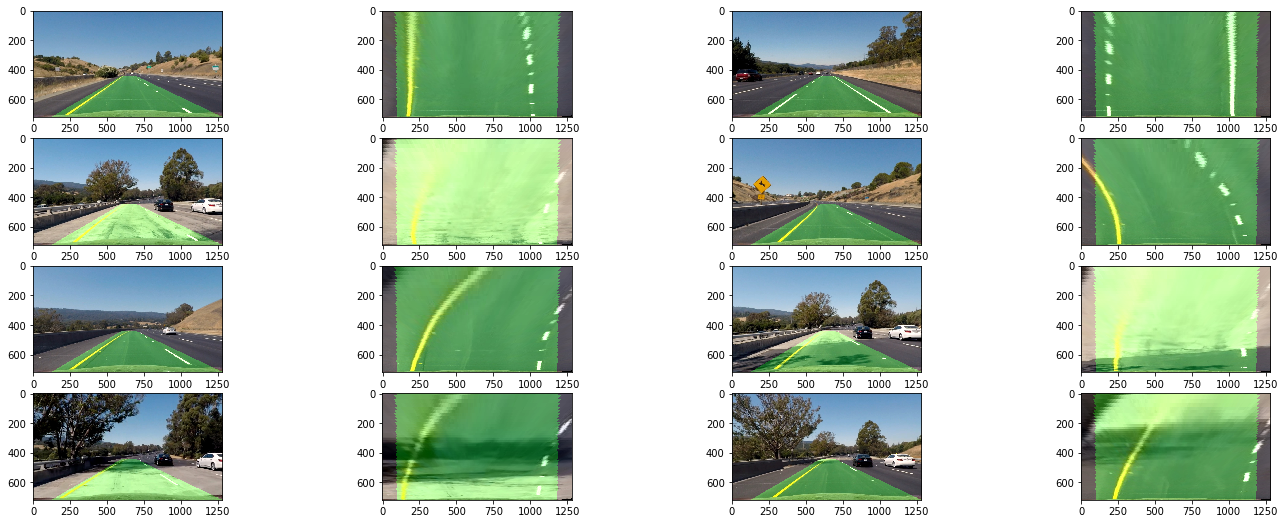

In [40]:
%matplotlib inline

def ShowPerspectiveTransformation(axs, fpath):

    images = glob.glob(fpath)
    
    for idx, fname in enumerate(images):
        
        img = mpimg.imread(fname)
        undistorted = cameraHelper.Undistort(img)
        
        poly = np.zeros_like(img)
        cv2.fillPoly(poly, np.int32([lanePoints]), (0,255, 0))
        undistorted = cv2.addWeighted(undistorted, 1, poly, 0.3, 0)

        axs[int(idx/2)][(idx % 2) * 2].imshow(undistorted)
        axs[int(idx/2)][(idx % 2) * 2 + 1].imshow(perspectiveTransformer.ToBirdsEyeView(undistorted), cmap = 'gray')

fig, axs = plt.subplots(4, 4, figsize=(24, 9))
ShowPerspectiveTransformation(axs, './test_images/*.jpg')

# Finding lane

In [48]:
class LaneFinder():

    def __init__(self):

        self.nwindows = 9
        self.margin = 100
        self.minpix = 50

        self.left_fit = None
        self.right_fit = None

    def FindLane(self, binary_warped):

        if self.left_fit is None or self.right_fit is None:

            return self.FindLaneForFirstFrame(binary_warped)

        else:

            return self.FindLaneForNonFirstFrame(binary_warped)

    def GetRadius(self):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        ploty = np.linspace(0, 719, num=720)
        y_eval = np.max(ploty)
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, self.leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, self.rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
        return left_curverad, right_curverad

    def FindLaneForFirstFrame(self, binary_warped):

        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/self.nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        self.left_lane_inds = []
        self.right_lane_inds = []
        
        self.margin = 100

        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            self.left_lane_inds.append(good_left_inds)
            self.right_lane_inds.append(good_right_inds)
            # If you found > self.minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                
            margin -= 10 #---------------- deepak

        # Concatenate the arrays of indices
        self.left_lane_inds = np.concatenate(self.left_lane_inds)
        self.right_lane_inds = np.concatenate(self.right_lane_inds)

        # Extract left and right line pixel positions
        self.leftx = nonzerox[self.left_lane_inds]
        self.lefty = nonzeroy[self.left_lane_inds] 
        self.rightx = nonzerox[self.right_lane_inds]
        self.righty = nonzeroy[self.right_lane_inds] 

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)

    def FindLaneForNonFirstFrame(self, binary_warped):

        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        self.left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] - self.margin)) &
                         (nonzerox < (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] + self.margin))) 
        self.right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] - self.margin)) &
                          (nonzerox < (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] + self.margin)))  

        # Again, extract left and right line pixel positions
        self.leftx = nonzerox[self.left_lane_inds]
        self.lefty = nonzeroy[self.left_lane_inds] 
        self.rightx = nonzerox[self.right_lane_inds]
        self.righty = nonzeroy[self.right_lane_inds]
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)

    def Visualize(self, fname, img, binary_warped):

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[self.left_lane_inds], nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[self.right_lane_inds], nonzerox[self.right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-self.margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+self.margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-self.margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+self.margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        fig, (axs1, axs2, axs3) = plt.subplots(1, 3, figsize=(24, 9))
        axs1.imshow(img)
        axs2.imshow(binary_warped, cmap = 'gray')
        axs3.imshow(result)
        
        axs1.set_title(fname)
        axs2.set_title('Birds eye view')
        axs3.set_title('Lanes')

        axs3.plot(left_fitx, ploty, color='yellow')
        axs3.plot(right_fitx, ploty, color='yellow')


In [49]:
laneFinder = LaneFinder()

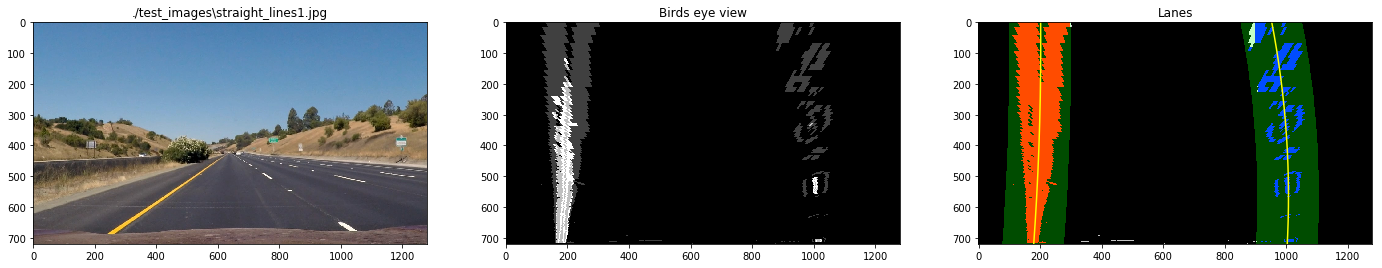

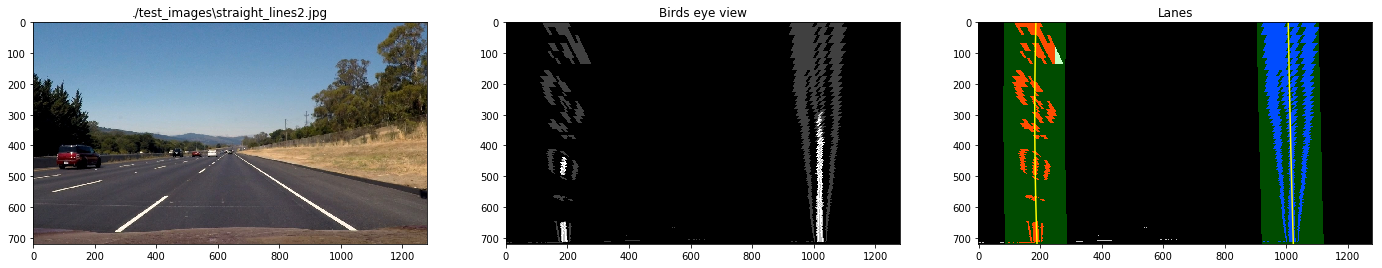

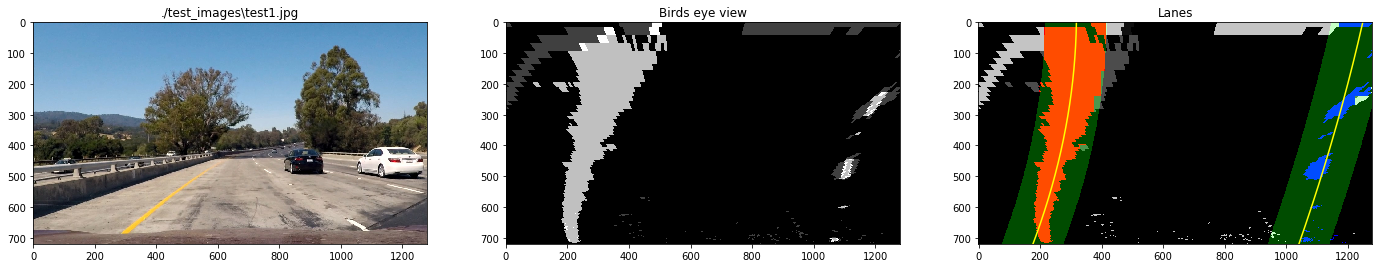

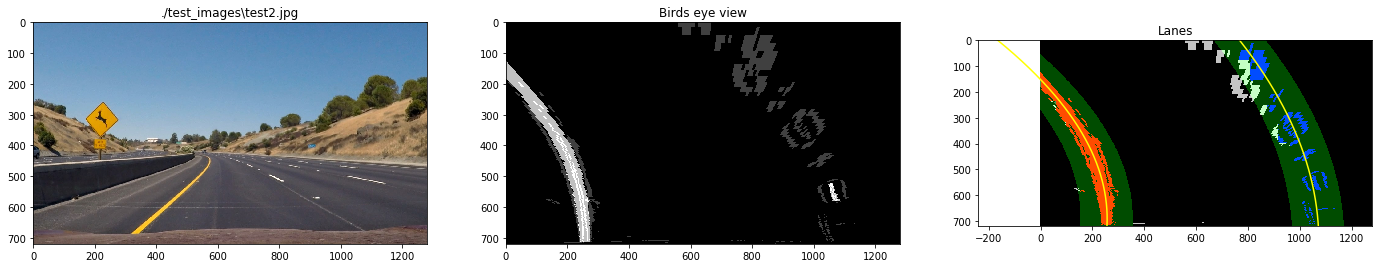

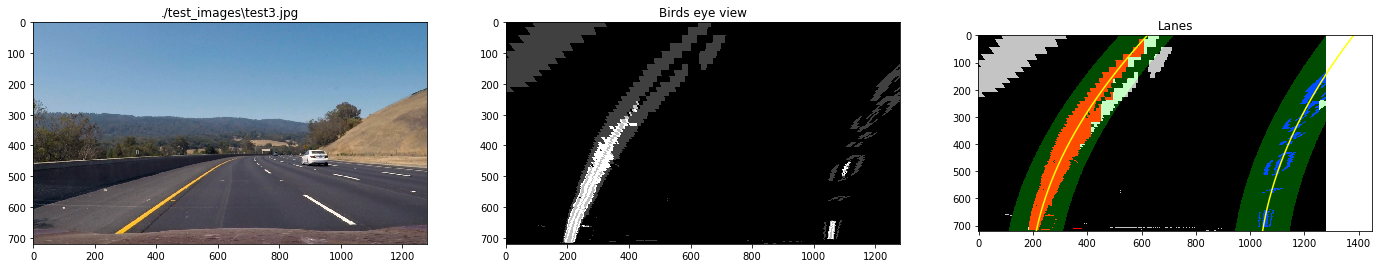

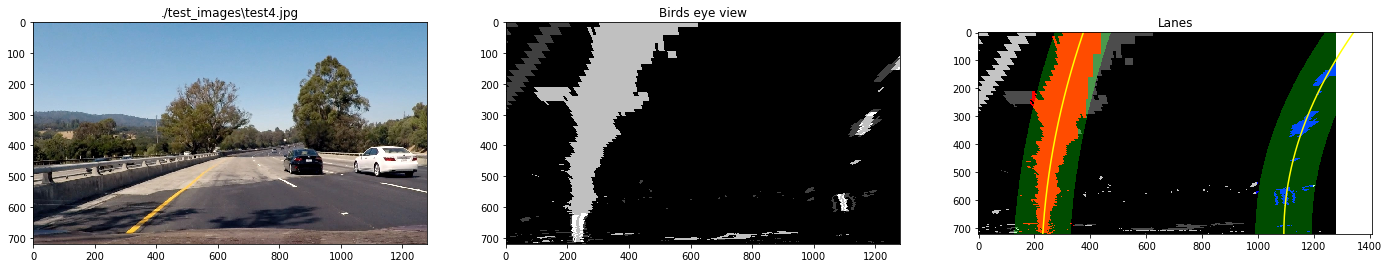

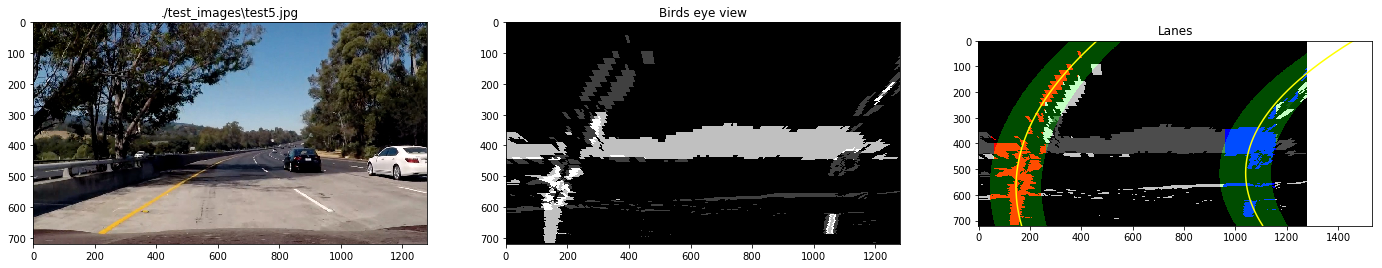

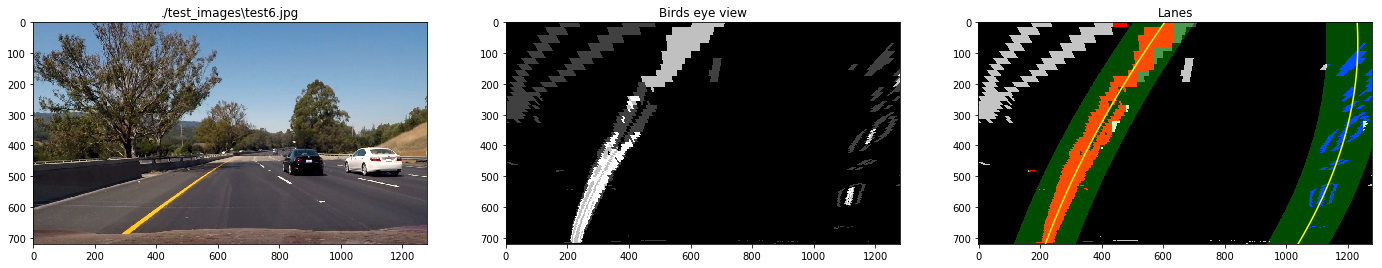

In [43]:
def LaneFindTest(fname):
    
    img = mpimg.imread(fname)
    undistorted = cameraHelper.Undistort(img)
    combined = thresholder.ApplySobelAndColorThreshold(undistorted)
    birdsEye = perspectiveTransformer.ToBirdsEyeView(combined)
    laneFinder.__init__()
    laneFinder.FindLane(birdsEye)
    laneFinder.Visualize(fname, img, birdsEye)
    
images = glob.glob('./test_images/*.jpg')
for idx, fname in enumerate(images):
    LaneFindTest(fname)

# Measure curvature radius

In [44]:
def drawLanes(image, undist, warped, ploty, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = perspectiveTransformer.ToDashCamView(color_warp) 
    # Combine the result with the original image
    return cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

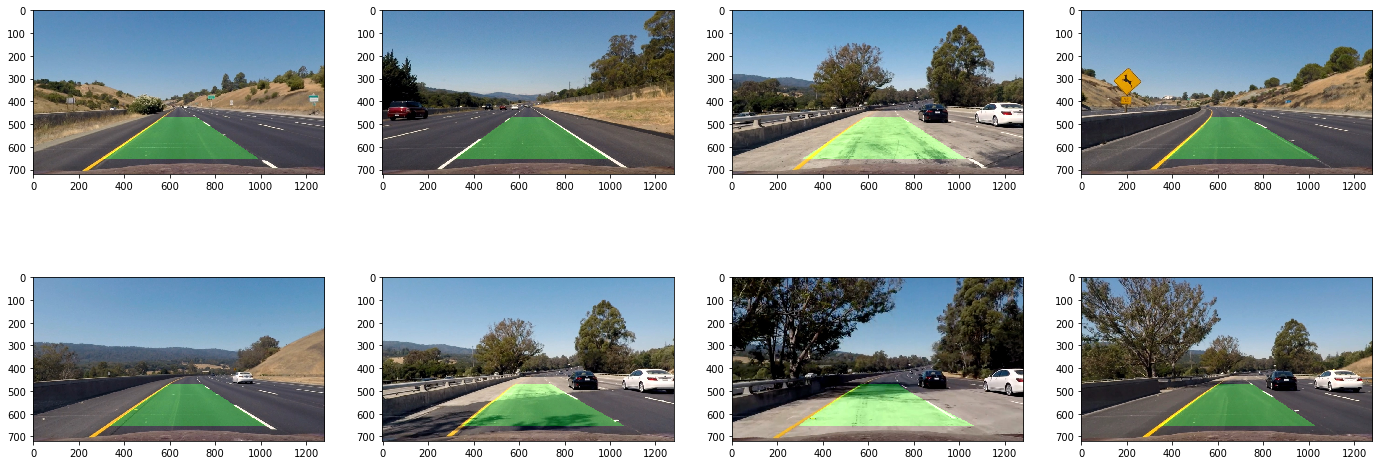

In [45]:
def pipeline(img):
    
    ploty = np.arange(400, 700, step=1)
    undistorted = cameraHelper.Undistort(img)
    combined = thresholder.ApplySobelAndColorThreshold(undistorted)
    birdsEye = perspectiveTransformer.ToBirdsEyeView(combined)
    laneFinder.FindLane(birdsEye)
    return drawLanes(img, undistorted, birdsEye, ploty, laneFinder.left_fit, laneFinder.right_fit)
    
images = glob.glob('./test_images/*.jpg')
fig, axs = plt.subplots(2, 4, figsize=(24, 9))
for idx, fname in enumerate(images):
    laneFinder.__init__()
    img = mpimg.imread(fname)
    axs[int(idx / 4)][idx % 4].imshow(pipeline(img))

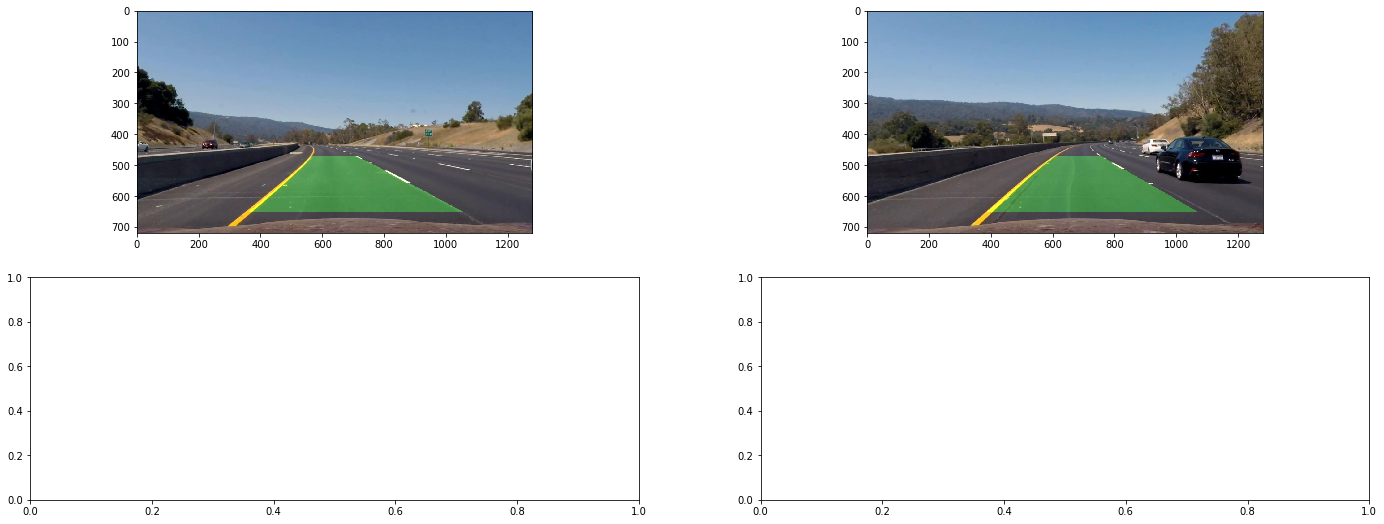

In [46]:
def SampleImages():
    testClip = VideoFileClip('./project_video.mp4')
    testClip.save_frame('./new_test_images/1.jpg', t=5)
    testClip.save_frame('./new_test_images/2.jpg', t=31)
    testClip.reader.close()
    testClip.audio.reader.close_proc()
#SampleImages()
fig, axs = plt.subplots(2, 2, figsize=(24, 9))
#ShowPerspectiveTransformation(axs, './new_test_images/*.jpg')
images = glob.glob('./new_test_images/*.jpg')
for idx, fname in enumerate(images):
    laneFinder.__init__()
    img = mpimg.imread(fname)
    axs[int(idx / 2)][idx % 2].imshow(pipeline(img))

# Create pipeline and run on videofrom moviepy.editor import VideoFileClip

In [47]:
def testOnVideo(inFile, outFile):
    testClip = VideoFileClip(inFile)
    result = testClip.fl_image(pipeline)
    %time result.write_videofile(outFile, audio=False)
    testClip.reader.close()
    testClip.audio.reader.close_proc()

testOnVideo('./project_video.mp4', './project_video_result.mp4')
#testOnVideo('./challenge_video.mp4', './challenge_video_result.mp4')

[MoviePy] >>>> Building video ./project_video_result.mp4
[MoviePy] Writing video ./project_video_result.mp4


100%|████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:20<00:00,  2.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_result.mp4 

Wall time: 5min 23s
